<a href="https://colab.research.google.com/github/alexcontarino/personal-projects/blob/main/NFL_Projects/Market_Implied_Pythagorean_Expectation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook uses the scraped moneyline data from the NFL Moneyline notebook to compute the implied exponent $c$ in the Pythagorean expectation equation for NFL games:

$$ \text{Pythagorean Wins} = \frac{\text{Points Scored}^c}{\text{Points Scored}^c + \text{Points Allowed}^c}$$

Two methods are used:
1. Implied win totals, points scored, and points allowed are computed from each game moneyline and total markets. The best value $c$ is then computed.
1. The market probabilities are used to define distributions of points scored for each team. From there, each game is simulated and the results from the simulated season are used to compute a best $c$ for that season. This is repeated 5000 times. While the overall best $c$ should be similar as from the first method, this simulation has the added benefit of providing the expected distribtuion of values for $c$ for a single season.

**What we see is that the market-implied value for $c$ from the implied win and point totals is 2.95. When the season is simulated, results tend to be more noisy and the mean value for the best $c$ is approximately 2.82.** This is more in line with my current estimate of $c$ for the NFL (see other notebook). The distribution of the best $c$ value for a season is roughly normally distributed (slight right skew) and standard deviation of 0.34.



## Set Up

In [2]:
import requests
from bs4 import BeautifulSoup
import re
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
from scipy.stats import norm
from google.colab import drive

In [3]:
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
gamelines = pd.read_csv('/content/drive/MyDrive/2025_gamelines.csv')

In [5]:
gamelines.head()

,away,home,home_spread,away_spread_line,home_spread_line,total,over_line,under_line,away_moneyline,home_moneyline,away_points,home_points,away_W_prob,home_W_prob,away_cover_prob,home_cover_prob,over_prob,under_prob
0,Cowboys,Eagles,-7,−110,−110,46.5,−110,−110,+250,−310,19.75,26.75,0.274247,0.725753,0.500000,0.500000,0.500000,0.500000
1,Chiefs,Chargers,3,−105,−115,45.5,−110,−110,−148,+124,24.25,21.25,0.572060,0.427940,0.489166,0.510834,0.500000,0.500000
2,Giants,Commanders,-7,−115,−105,45.5,−105,−115,+220,−270,19.25,26.25,0.299838,0.700162,0.510834,0.489166,0.489166,0.510834
3,Bengals,Browns,5,−110,−110,44.5,−115,−105,−230,+190,24.75,19.75,0.669007,0.330993,0.500000,0.500000,0.510834,0.489166
4,Steelers,Jets,3,−102,−118,39.5,−110,−110,−155,+130,21.25,18.25,0.582993,0.417007,0.482636,0.517364,0.500000,0.500000


In [6]:
teams = gamelines.away.unique()

## Helper Functions

In [7]:
def PythW(scored, allowed, c):

  return (scored**c) / ((scored**c) + (allowed**c))

In [8]:
def SSE(Y, P):

  return np.sum((Y - P)**2)

The function below is a silly little algorithm to find a suitable value for $c$ in the Pythagorean Expectation equation. Taking advantage of the 1-d search space and the convexity of the cost function (sum of squared errors), it executes increasingly finer grid searches to arrive at a value for $c$ at user-given level of precision.

The "errors" of sum of squared errors being minimized are the differences between each team's projected win total from the betting lines and the expected number of wins from the Pythagorean expectation using projected points scored, points allowed, and a value $c$.

In [9]:
def find_c(team_outcomes_df, grid_start, grid_stop, grid_density, grid_cut, precision):

  # simple grid search. refine grid each generation by reducing grid length by specified grid_cut. stop after certain precision is reached.
  # determine iterations to reach requested precision
  log_base = 1 / grid_cut
  iterations = math.ceil(math.log((grid_stop - grid_start) / precision, log_base)) + 1

  #print(f"Iterations to Complete: {iterations}")

  min_SSE = np.inf   # initialize variables
  best_c = np.inf
  Y = team_outcomes_df["W"].to_numpy()   # grab T actual

  for iter in range(iterations):
    # create grid
    grid = np.linspace(grid_start, grid_stop, grid_density)
    grid_length = grid_stop - grid_start

    # evaluate each c in grid
    for c in grid:
      P_c = PythW(team_outcomes_df["Points_Scored"], team_outcomes_df["Points_Allowed"], c)
      team_outcomes_df["Pyth_W"] = team_outcomes_df["Games"] * P_c
      SSE_c = SSE(Y, team_outcomes_df["Pyth_W"])
      if SSE_c < min_SSE:
        min_SSE = SSE_c
        best_c = c

    # set up next iter
    grid_start = best_c - (grid_length * grid_cut / 2)
    grid_stop = best_c + (grid_length * grid_cut / 2)

    #print(f"Iteration {iter+1} Complete! Best c value: {best_c}. SSE: {min_SSE}")

  return best_c

## Method 1: Implied Wins and Points

### Step 1: Compute Projected Wins

In [10]:
team_data_list = {}

for game in gamelines.iterrows():
  game = game[1]
  for team_type in ["away", "home"]:
    team = game[f"{team_type}"]
    team_W = game[f"{team_type}_W_prob"]
    if math.isnan(game["away_points"]):
      continue
    if team_type == "away":
      team_points_scored = game["away_points"]
      team_points_allowed = game["home_points"]
    else:
      team_points_scored = game["home_points"]
      team_points_allowed = game["away_points"]

    if team not in team_data_list:
      team_data_list[team] = {"Games": 0, "W": 0, "Points_Scored": 0, "Points_Allowed": 0}

    team_data_list[team]["Games"] += 1
    team_data_list[team]["W"] += team_W
    team_data_list[team]["Points_Scored"] += team_points_scored
    team_data_list[team]["Points_Allowed"] += team_points_allowed

team_outcomes_df = pd.DataFrame.from_dict(team_data_list, orient='index')

In [11]:
team_outcomes_df["Point_Diff"] = team_outcomes_df["Points_Scored"] - team_outcomes_df["Points_Allowed"]
team_outcomes_df["Average_W_Prob"] = team_outcomes_df["W"] / team_outcomes_df["Games"]
team_outcomes_df

,Games,W,Points_Scored,Points_Allowed,Point_Diff,Average_W_Prob
Cowboys,16,6.996661,357.50,389.50,-32.0,0.437291
Eagles,15,9.257084,373.25,317.25,56.0,0.617139
Chiefs,16,10.066833,402.50,337.50,65.0,0.629177
Chargers,16,8.937031,375.00,346.00,29.0,0.558564
Giants,15,5.373453,294.25,361.25,-67.0,0.358230
Commanders,16,9.213021,401.50,362.50,39.0,0.575814
Bengals,16,8.591284,390.50,376.50,14.0,0.536955
Browns,16,5.300798,299.50,385.50,-86.0,0.331300
Steelers,16,7.499474,344.50,359.50,-15.0,0.468717
Jets,16,6.153672,316.50,374.50,-58.0,0.384604


### Step 2: Apply Algorithm

In [12]:
best_c = find_c(team_outcomes_df, 0.5, 5, 100, .1, 1e-5)
print(f"Best c value: {round(best_c,3)}")

Best c value: 2.955


## Results

In [13]:
team_outcomes_df["Pyth_W"] = PythW(team_outcomes_df["Points_Scored"], team_outcomes_df["Points_Allowed"], best_c)
team_outcomes_df

,Games,W,Points_Scored,Points_Allowed,Point_Diff,Average_W_Prob,Pyth_W
Cowboys,16,6.996661,357.50,389.50,-32.0,0.437291,0.437004
Eagles,15,9.257084,373.25,317.25,56.0,0.617139,0.617835
Chiefs,16,10.066833,402.50,337.50,65.0,0.629177,0.627258
Chargers,16,8.937031,375.00,346.00,29.0,0.558564,0.559182
Giants,15,5.373453,294.25,361.25,-67.0,0.358230,0.352926
Commanders,16,9.213021,401.50,362.50,39.0,0.575814,0.574921
Bengals,16,8.591284,390.50,376.50,14.0,0.536955,0.526946
Browns,16,5.300798,299.50,385.50,-86.0,0.331300,0.321708
Steelers,16,7.499474,344.50,359.50,-15.0,0.468717,0.468555
Jets,16,6.153672,316.50,374.50,-58.0,0.384604,0.378189


## Method 2: We Can Simulate That

*Note okay so a few things:

 - c = 2.95ish calculated above tracks a little higher than recent historical results
 - Sim'ing the season *should* yield similar values of c as above, but also helpful to see its variance

Will execute the following algorithm:

Simulate the season 5000 (maybe 10000) times

Within each season for each game:

- Convert spread and win prob into a Normal distribution with mean $\mu$ and standard deviation $s$
  - Assume that standard deviation of points scored is same for both teams ($\sigma$) such that $s = \sqrt{2}\sigma$

  - Assumption may not be exactly correct but a simple one to start from. Can try to confirm with historics.

- Simulate home and away scores (round to nearest whole number)

- Determine game winner (tie -- 0.5 wins --- if home and away scores are the same)

- Add results to data frame

Once season simulation is complete, find min $SSE$ estimate for $c$ in Pythagorean Expectation of wins

Repeat 10000 times

Examine distribution of $c$

### More Helper Functions

In [14]:
def sigma_finder(spread, home_cover, home_W_prob, max_sigma=None):

  # compute the standard deviation of total point scored based on home win probability and home cover probability
  # Assume the distribution of points scored is Normal
  # Then we have two points from which we can compute a standard deviation for this Normal distribution
  # The home cover probability (approximately at mean) is one point
  # The home win probability is the second

  # sigma = (value2 - value1) / (z2 - z1)

  spread = -1 * np.float64(spread)

  if spread > 0:

    value2 = spread
    value1 = 0

    z2 = norm.ppf(1 - home_cover)
    z1 = norm.ppf(1 - home_W_prob)

  else:

    value1 = spread
    value2 = 0

    z1 = norm.ppf(1 - home_cover)
    z2 = norm.ppf(1 - home_W_prob)

  return (value2 - value1) / (z2 - z1)

In [15]:
gamelines["Sigma"] = gamelines.apply(lambda x: sigma_finder(x["home_spread"], x["home_cover_prob"], x["home_W_prob"]), axis=1)
gamelines.head()

,away,home,home_spread,away_spread_line,home_spread_line,total,over_line,under_line,away_moneyline,home_moneyline,away_points,home_points,away_W_prob,home_W_prob,away_cover_prob,home_cover_prob,over_prob,under_prob,Sigma
0,Cowboys,Eagles,-7,−110,−110,46.5,−110,−110,+250,−310,19.75,26.75,0.274247,0.725753,0.500000,0.500000,0.500000,0.500000,11.666338
1,Chiefs,Chargers,3,−105,−115,45.5,−110,−110,−148,+124,24.25,21.25,0.572060,0.427940,0.489166,0.510834,0.500000,0.500000,14.369122
2,Giants,Commanders,-7,−115,−105,45.5,−105,−115,+220,−270,19.25,26.25,0.299838,0.700162,0.510834,0.489166,0.489166,0.510834,12.680529
3,Bengals,Browns,5,−110,−110,44.5,−115,−105,−230,+190,24.75,19.75,0.669007,0.330993,0.500000,0.500000,0.510834,0.489166,11.437122
4,Steelers,Jets,3,−102,−118,39.5,−110,−110,−155,+130,21.25,18.25,0.582993,0.417007,0.482636,0.517364,0.500000,0.500000,11.853279


In [17]:
mean_std = gamelines.Sigma.mean()
print(f"Mean Standard Deviation of Points Scored in A Game: {round(mean_std,3)}")

Mean Standard Deviation of Points Scored in A Game: 13.517


In [18]:
def sim_game(away_points, home_points, spread, home_cover_prob, home_W_prob, rng):

  # simulate game (points scored and winner)

  # compute standad deviation of total point scored
  sigma = sigma_finder(spread, home_cover_prob, home_W_prob)
  # compute standard deviations of each teams' point scored
  # assume these are equal and distributions Normal
  # Then...
  s = sigma / np.sqrt(2)

  # points are random draws from normal distribution N(XXXX_points, s), rounded to whole numbers, and floored at 0
  away_score = np.max([0, round(rng.normal(away_points, s))])
  home_score = np.max([0, round(rng.normal(home_points, s))])

  return away_score, home_score

In [19]:
def sim_season(gamelines, rng):

  team_data_list = {}

  for game in gamelines.iterrows():
    game = game[1]
    if math.isnan(game["away_points"]):
      continue

    # grab game data
    spread = game["home_spread"]
    home_cover_prob = game["home_cover_prob"]
    home_W_prob = game["home_W_prob"]

    away_team = game["away"]
    home_team = game["home"]

    away_points = game["away_points"]
    home_points = game["home_points"]

    # sim game
    away_score, home_score = sim_game(away_points, home_points, spread, home_cover_prob, home_W_prob, rng)

    # update games played for each team
    for team in [away_team, home_team]:
      if team not in team_data_list:
        team_data_list[team] = {"Games": 0, "W": 0, "Points_Scored": 0, "Points_Allowed": 0}
      team_data_list[team]["Games"] += 1

    # update wins
    if away_score > home_score:
      team_data_list[away_team]["W"] += 1
    elif home_score > away_score:
      team_data_list[home_team]["W"] += 1
    else:
      team_data_list[away_team]["W"] += 0.5
      team_data_list[home_team]["W"] += 0.5

    # update home team points scored and allowed
    team_data_list[home_team]["Points_Scored"] += home_score
    team_data_list[home_team]["Points_Allowed"] += away_score

    # update away team points scored and allowed
    team_data_list[away_team]["Points_Scored"] += away_score
    team_data_list[away_team]["Points_Allowed"] += home_score

  team_outcomes_df = pd.DataFrame.from_dict(team_data_list, orient='index')

  team_outcomes_df["Average_W_Prob"] = team_outcomes_df["W"] / team_outcomes_df["Games"]
  team_outcomes_df["Point_Diff"] = team_outcomes_df["Points_Scored"] - team_outcomes_df["Points_Allowed"]

  return team_outcomes_df

### Main Loop

In [21]:
n_seasons = 5000
best_c = []

rng = np.random.default_rng(seed=69)

for season in range(n_seasons):
  team_outcomes_df = sim_season(gamelines, rng)
  best_c.append(find_c(team_outcomes_df, 0.5, 5, 100, .1, 1e-5))
  team_outcomes_df.reset_index(inplace=True)
  team_outcomes_df.rename(columns={"index": "Team"}, inplace=True)
  team_outcomes_df["season"] = season + 1
  if season == 0:
    all_season_team_results = team_outcomes_df
  else:
    all_season_team_results = pd.concat([all_season_team_results, team_outcomes_df])
  if (season + 1) % 100 == 0:
    print(f"{season + 1} Seasons Complete!")

100 Seasons Complete!
200 Seasons Complete!
300 Seasons Complete!
400 Seasons Complete!
500 Seasons Complete!
600 Seasons Complete!
700 Seasons Complete!
800 Seasons Complete!
900 Seasons Complete!
1000 Seasons Complete!
1100 Seasons Complete!
1200 Seasons Complete!
1300 Seasons Complete!
1400 Seasons Complete!
1500 Seasons Complete!
1600 Seasons Complete!
1700 Seasons Complete!
1800 Seasons Complete!
1900 Seasons Complete!
2000 Seasons Complete!
2100 Seasons Complete!
2200 Seasons Complete!
2300 Seasons Complete!
2400 Seasons Complete!
2500 Seasons Complete!
2600 Seasons Complete!
2700 Seasons Complete!
2800 Seasons Complete!
2900 Seasons Complete!
3000 Seasons Complete!
3100 Seasons Complete!
3200 Seasons Complete!
3300 Seasons Complete!
3400 Seasons Complete!
3500 Seasons Complete!
3600 Seasons Complete!
3700 Seasons Complete!
3800 Seasons Complete!
3900 Seasons Complete!
4000 Seasons Complete!
4100 Seasons Complete!
4200 Seasons Complete!
4300 Seasons Complete!
4400 Seasons Complet

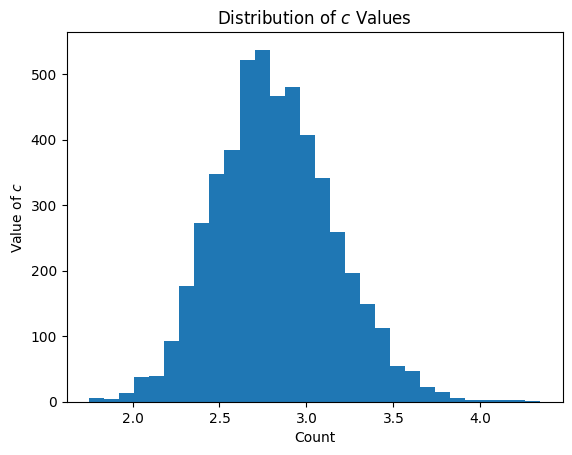

In [22]:
plt.hist(best_c, bins=30)
plt.xlabel("Count")
plt.ylabel("Value of $c$")
plt.title("Distribution of $c$ Values")
plt.show()

In [23]:
mean_best_c = np.mean(best_c)
std_best_c = np.std(best_c)
print(f"Mean: {round(mean_best_c,3)}")
print(f"Standard Deviation: {round(std_best_c,3)}")

Mean: 2.821
Standard Deviation: 0.339


## Archive

In [24]:
all_season_team_results.head(32).sort_values("Average_W_Prob", ascending=False)

,Team,Games,W,Points_Scored,Points_Allowed,Average_W_Prob,Point_Diff,Pyth_W,season
16,Dolphins,16,13.0,407,284,0.812500,123,11.564243,1
2,Chiefs,16,12.0,440,307,0.750000,133,11.564995,1
23,Seahawks,17,12.0,453,347,0.705882,106,11.396239,1
6,Bengals,16,11.0,370,330,0.687500,40,9.209319,1
31,Bears,16,11.0,363,305,0.687500,58,9.821845,1
28,Ravens,16,11.0,392,304,0.687500,88,10.609112,1
29,Bills,15,10.0,351,302,0.666667,49,8.981733,1
0,Cowboys,16,10.5,398,300,0.656250,98,10.876352,1
14,Cardinals,17,11.0,424,368,0.647059,56,10.084371,1
13,Patriots,16,9.0,378,318,0.562500,60,9.809234,1


In [25]:
np.mean(best_c)

np.float64(2.8209535658681815)

In [26]:
results = all_season_team_results.groupby("Team").mean()
results["adj_W"] = 17 * results["Average_W_Prob"]
results.sort_values("adj_W", ascending=False)

,Games,W,Points_Scored,Points_Allowed,Average_W_Prob,Point_Diff,Pyth_W,season,adj_W
Team,,,,,,,,,
Bills,15.0,10.0821,395.1268,314.7544,0.672140,80.3724,9.764649,2500.5,11.426380
Ravens,16.0,10.6378,421.1606,339.0388,0.664863,82.1218,10.307900,2500.5,11.302663
Chiefs,16.0,10.0714,403.1510,337.9090,0.629463,65.2420,9.894733,2500.5,10.700863
Eagles,15.0,9.2649,373.7618,317.9724,0.617660,55.7894,9.127864,2500.5,10.500220
49ers,17.0,10.3525,421.8482,365.2454,0.608971,56.6028,10.159086,2500.5,10.352500
Commanders,16.0,9.2669,401.5132,363.0470,0.579181,38.4662,9.102428,2500.5,9.846081
Lions,16.0,9.1656,402.0408,366.1900,0.572850,35.8508,9.013445,2500.5,9.738450
Broncos,16.0,9.1504,373.8546,341.0082,0.571900,32.8464,8.998307,2500.5,9.722300
Buccaneers,15.0,8.5759,372.3776,339.5902,0.571727,32.7874,8.442428,2500.5,9.719353


In [27]:
team_results = {}

for team in teams:
  team_results[team] = all_season_team_results[all_season_team_results["Team"] == team]

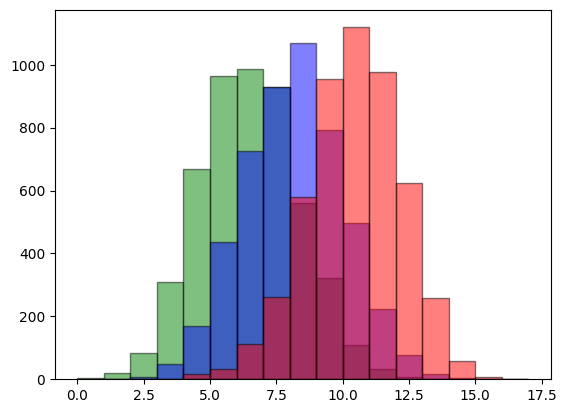

In [28]:
bins = np.arange(0, 18, 1)

plt.hist(team_results["Jets"].W, bins=bins, alpha=0.5, edgecolor='black', color="green")
plt.hist(team_results["Patriots"].W, bins=bins, alpha=0.5, edgecolor='black', color="blue")
plt.hist(team_results["Bills"].W, bins=bins, alpha=0.5, edgecolor='black', color="red")
plt.show()